### Linear Regression the Bayesian Way
* The Bayes by Backprop approach

In [1]:
# Checking if running in colab and if installing the requited versions
# Trick from: https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab 
try:
  import google.colab
  IN_COLAB = True
  !pip install tensorflow==2.0.0-alpha0
  !pip install tfp-nightly
except:
  IN_COLAB = False

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline
tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190426
TF  Version 2.0.0-alpha0


Creation of some data

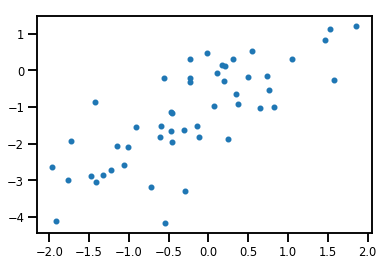

In [33]:
num = 50
np.random.seed(42)
#x = np.concatenate((np.linspace(-10,-1,num), np.linspace(1,10,num))).reshape(2*num,1)
np.random.seed(42)
x = np.random.normal(0,1,(num,1))
y = 1 * x[:,0] - 1 + np.random.normal(0,1,num) 
plt.scatter(x,y, marker='.')
x.shape, y.shape, y.dtype
ytensor = y.reshape([len(y),1])

### Fitting a linear model (Max Likelihood)

In [34]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
print('Coefficients: \n', regr.coef_)
print('Coefficients: \n', regr.intercept_)

Coefficients: 
 [1.10307565]
Coefficients: 
 -0.9589782612132034


### Variatioal inference by hand

The Variational Inference involves the calculation of the KL Divergence between

$$
KL(p(q|\theta) || P(w) 
$$

For Gaussians we can calculate this as (see Kingma Welling 2013 VAE paper in the appendix)

$$
    KL(q(\mu_1|\sigma_1) || N(0,1)) = -\frac{1}{2} \left{ log(\sigma^2) - \mu^2 - \sigma^2 \right}
$$


In [35]:
mu = 1.
s  = 2.
print(tfd.Normal(mu, s).kl_divergence(tfd.Normal(0, 1)))
-(1. + np.log(s**2) - mu - s**2)/2.


tf.Tensor(1.3068528, shape=(), dtype=float32)


1.3068528194400546

In [36]:
# Variational parameters
# 0 b_u =  tf.Variable(0.0) # Mean of bias / intercept term
# 1 b_r =  tf.Variable(-3.0) # Rho of bias  / intercept term
# 2 a_u =  tf.Variable(0.0) # Same for intecept
# 3 a_r =  tf.Variable(-3.0)
w = tf.Variable((0,-3.0,0,-3.0)) #We need all in one array 

# The noise term
e = tfd.Normal(loc=0., scale=1.)

# The Distributions of the weights and the biases
# a_rv = tfd.Normal(w[2], tf.math.softplus(w[3]))
# b_rv = tfd.Normal(w[0], tf.math.softplus(w[1]))

# The priors  we need 0,1 due to KL-Divergence
pa = tfd.Normal(loc=0., scale=1)
pb = tfd.Normal(loc=0., scale=1)

epochs = 1000

loss_history = np.zeros(epochs)
loss_history_mse = np.zeros(epochs)
loss_history_kl = np.zeros(epochs)
loss_history_kl2 = np.zeros(epochs)
for i in range(epochs):
    with tf.GradientTape() as tape: 
        # The linear regression with the reparameterization trick
        sa = tf.math.softplus(w[3])
        sb = tf.math.softplus(w[1])
        y_hat = (w[2] + e.sample() * sa) * x + w[0] + e.sample()*sb
        loss_mse = tf.reduce_sum(tf.math.square(ytensor - y_hat))
        #KL-Divergence with Gaussian Priors 
        loss_kl = -0.5*(tf.math.log(sa*sa) - sa*sa - w[2]*w[2] + tf.math.log(sb*sb) - sb*sb - w[0]*w[0])
        #loss_kl = pa.kl_divergence(a_rv) + pb.kl_divergence(b_rv) #also to MaxLike
        loss = loss_mse + loss_kl
        loss_history[i] = loss.numpy()
        loss_history_kl[i] = loss_kl.numpy()
        loss_history_mse[i] = loss_mse.numpy()
    grads = tape.gradient(loss, w)
    #w = w - 0.0001*grads # Does not work in eager
    w = tf.Variable(w - 0.0001*grads) # Gradient Descent 
    

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([-0.95049417, -2.9281611 ,  1.0938781 , -2.9307148 ], dtype=float32)>
b =  -0.95049417   0.05211348  a =  1.0938781   0.051984023


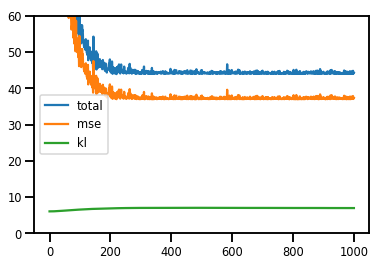

In [37]:
print(w)
plt.plot(loss_history)
plt.plot(loss_history_mse)
plt.plot(loss_history_kl)
plt.ylim(0,60)
plt.legend(('total', 'mse', 'kl', 'kl_1'))
plt.show()
print('b = ', w[0].numpy(), ' ', tf.math.softplus(w[1]).numpy(), 
      ' a = ', w[2].numpy(), ' ',  tf.math.softplus(w[3]).numpy())